In [82]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import seaborn as sns
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)

from scipy.special import gamma as fgamma
def gamma(x, a, b):
    '''pdf of gamma(shape, rate)'''
    return b ** a / fgamma(a) * x ** (a - 1) * np.exp(-b * x)

In [2]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 3.28 s, sys: 202 ms, total: 3.48 s
Wall time: 3.62 s


In [3]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [4]:
p_stay = []
for i in np.arange(12):
    df_small = df_corr_all[(df_corr_all['MouseID'] == i)]
    p_stay.append( len(df_small[df_small['Stay/Leave'] == 'stay']) / len(df_small))

In [5]:
np.mean(p_stay)

0.76581704735989931

In [6]:
df_corr_DMS = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr_NaC = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'NaC'])


In [7]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS

for df_i in [df_corr_DMS, df_corr_NaC]:

    df_i['bQ_dir_diff'] = pd.cut(df_i['Q_dir_diff'], Q_BINS)
    df_i['bQ_ch_diff'] = pd.cut(df_i['Q_ch_diff'], Q_BINS)

    # quantile cuts for raw Q values 
    df_i['bQ_chosen'] = pd.qcut(df_i['Q_chosen'], Q_BINS_QUANTILES)
    df_i['bQ_c'] = pd.qcut(df_i['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


# Figure 1

Text(0.5,1,'Lever Presentation')

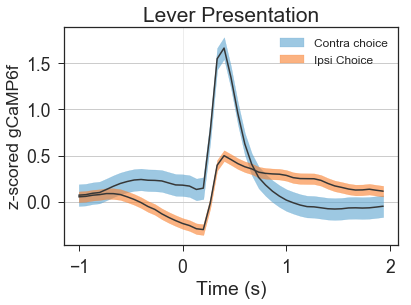

In [50]:
sz = 12 
categories = ['Con', 'Ips']
column = 'Action'
cat_names = ['Contra choice', 'Ipsi Choice']
            
ax = plt.gca()
palettes = [ 'Blues', 'Oranges']


for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(palette, len(qlims))

    gcamp = np.vstack(df_src[timelocked])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(gcamp, axis = 0)
    col = color_palette[5]
    lw = 1.5

    error = np.std(y, axis = 0) / np.sqrt(NS)
    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
        
        

plt.ylabel('z-scored gCaMP6f', size = 'small')


                
ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

ax.set_xlabel('Time (s)')

plt.legend( fontsize = sz)
ax.set_title('Lever Presentation')

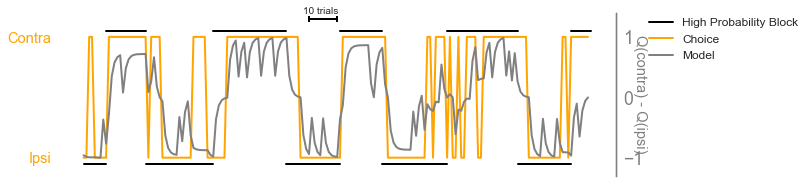

In [8]:
sz = 12 
figure = plt.figure(figsize=(10,3))
sns.set_style('ticks')


ax = plt.gca()
l2, = ax.plot(c[0,30:210] * -2 + 1, color = 'orange', lw = 2, label = 'Choice')
ax.tick_params(axis = 'y', length = 0, color = 'k')
ax.yaxis.set_visible(True) 
ax.set_yticklabels(['', 'Ipsi', '', 'Contra'], color = 'orange', size = 'x-small')
ax.set_xticks([])

ax2 = ax.twinx()
l3, = ax2.plot(df_corr_DMS[df_corr_DMS['MouseID'] == 0].Q_dir_diff.values[31:211], color = 'grey', lw = 2, label = 'Model')
ax2.set_ylabel('Q(contra) - Q(ipsi)', size = 'x-small', color = 'grey', rotation = -90)
ax2.tick_params(axis = 'y', labelcolor = 'grey', length = 0)

sns.despine(ax = ax, left = False, right = False, bottom = True)
sns.despine(ax = ax2, left = True, right = False, bottom = True)
ax.spines['left'].set_color('white')
ax2.spines['right'].set_color('grey')

highprob_blocks = df_trials.HighProb.values[30:210]
highprob_blocks[highprob_blocks == 'Ips'] = -1.1
highprob_blocks[highprob_blocks == 'Con'] = 1.1

xmin = 0 
curr = highprob_blocks[0]
for i, data in enumerate(highprob_blocks):
    if data != curr:
        xmax = i
        ax.plot([xmin, xmax], [curr, curr],  color = 'k', lw = 2)
        xmin = xmax
        curr = data
    elif i == len(highprob_blocks) - 1:
        ax.plot([xmin, len(highprob_blocks)], [curr, curr],  color = 'k', lw = 2)
ax.set_ylim(-1.3, 1.4)
ax2.set_ylim(-1.3, 1.4)

ax.errorbar(x = 85, y = 1.3, xerr = 5, capsize=3, elinewidth=2, capthick=2, color = 'k')
ax.text(x = 78, y = 1.38, s='10 trials', size =10)
l1, = plt.plot([], color = 'k', lw = 2, label = 'High Probability Block')
lgd = plt.legend(handles = [l1, l2, l3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = sz)


Done


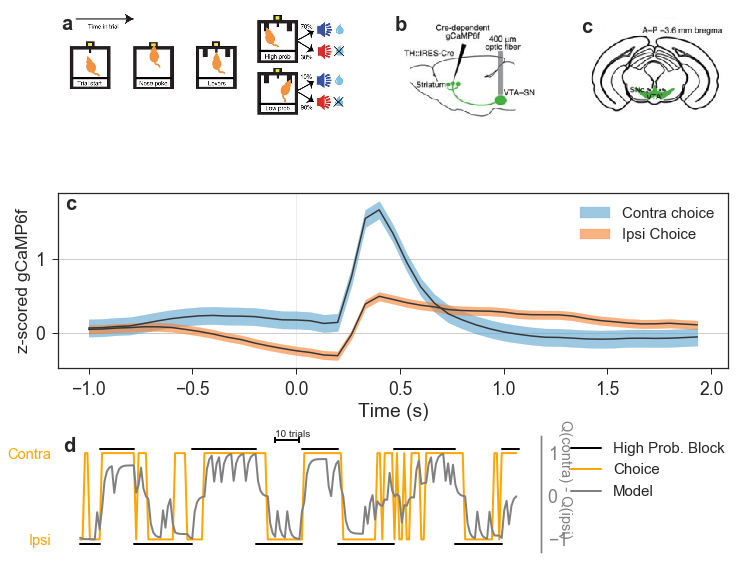

In [154]:
sz = 15

def set_figure(ax):
    ax.set_yticks([])
    ax.set_xticks([])

# palettes 

figure = plt.figure(figsize=(12,10))
subfigs = np.array(['a', 'b','c', 'd'])
gs = gridspec.GridSpec(3, 3, height_ratios = [1, 1.5, 1], width_ratios = [0.5, 0.25, 0.25])
gs.update(hspace=0.5)

############################ MICE TASK ############################

ax = plt.subplot(gs[0, 0])
ax.annotate(subfigs[0], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
im = mpimg.imread('figs/schematics/schematic_v2.png')
ax.imshow(im) # , aspect='auto')
ax.set_xticks([])
ax.axis('off')

############################ BRAIN SCHEMATICS ############################

ax = plt.subplot(gs[0,1])
ax.annotate(subfigs[1], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
im = mpimg.imread('figs/schematics/fig7a.png')
ax.imshow(im) # , aspect = 'auto')

ax.set_xticks([])
ax.axis('off')

ax = plt.subplot(gs[0,2])
ax.annotate(subfigs[2], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
im = mpimg.imread('figs/schematics/fig7b.png')
ax.imshow(im) #, aspect = 'auto')

ax.set_xticks([])
ax.axis('off')

############################ NATHAN DMS RESULTS ############################


ax = plt.subplot(gs[1, :])
ax.annotate(subfigs[-2], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
categories = ['Con', 'Ips']
column = 'Action'
cat_names = ['Contra choice', 'Ipsi Choice']
timelocked = 'g_lp'

palettes = [ 'Blues', 'Oranges']
subcat = ''

for subcat_i, [subcat_name, subcat, palette] in enumerate(zip(cat_names, categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(palette, len(qlims))

    gcamp = np.vstack(df_src[timelocked])
    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
    y = np.mean(gcamp, axis = 0)
    col = color_palette[5]
    lw = 1.5

    error = np.std(y, axis = 0) / np.sqrt(NS)
    ax.plot(x, y, color = '#363737', linewidth = lw)
    ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6, label = subcat_name)
                
        
        

plt.ylabel('z-scored gCaMP6f', size = 'small')


                
ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

ax.set_xlabel('Time (s)')

plt.legend( fontsize = sz)
# ax.set_title('Lever Presentation')

############################ MODEL ############################

ax = plt.subplot(gs[-1,:2])


ax.annotate(subfigs[-1], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')

l2, = ax.plot(c[0,30:210] * -2 + 1, color = 'orange', lw = 2, label = 'Choice')
ax.tick_params(axis = 'y', length = 0, color = 'k')
ax.yaxis.set_visible(True) 
ax.set_yticklabels(['', 'Ipsi', '', 'Contra'], color = 'orange', size = 'x-small')
ax.set_xticks([])

ax2 = ax.twinx()
l3, = ax2.plot(df_corr_DMS[df_corr_DMS['MouseID'] == 0].Q_dir_diff.values[31:211], color = 'grey', lw = 2, label = 'Model')
ax2.set_ylabel('Q(contra) - Q(ipsi)       ', size = 'x-small', color = 'grey', rotation = -90)
ax2.tick_params(axis = 'y', labelcolor = 'grey', length = 0)

sns.despine(ax = ax, left = False, right = False, bottom = True)
sns.despine(ax = ax2, left = True, right = False, bottom = True)
ax.spines['left'].set_color('white')
ax2.spines['right'].set_color('grey')

highprob_blocks = df_trials.HighProb.values[30:210]
highprob_blocks[highprob_blocks == 'Ips'] = -1.1
highprob_blocks[highprob_blocks == 'Con'] = 1.1

xmin = 0 
curr = highprob_blocks[0]
for i, data in enumerate(highprob_blocks):
    if data != curr:
        xmax = i
        ax.plot([xmin, xmax], [curr, curr],  color = 'k', lw = 2)
        xmin = xmax
        curr = data
    elif i == len(highprob_blocks) - 1:
        ax.plot([xmin, len(highprob_blocks)], [curr, curr],  color = 'k', lw = 2)

ax.set_ylim(-1.3, 1.4)
ax2.set_ylim(-1.3, 1.4)

ax.errorbar(x = 85, y = 1.3, xerr = 5, capsize=3, elinewidth=2, capthick=2, color = 'k')
ax.text(x = 80, y = 1.38, s='10 trials', size =10)
l1, = plt.plot([], color = 'k', lw = 2, label = 'High Prob. Block')
lgd = plt.legend(handles = [l1, l2, l3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = sz)

# plt.subplots_adjust(right = 0.8)

plt.savefig('figs/Fig1', dpi=200)
print('Done')



# Figure 2

In [136]:
####### COLORS/BASIC PLOTS/FOR THE THEORY PLOTS
# basic plot 

meanlag = 6
stddev = 2

a = (meanlag/stddev) ** 2
b = meanlag/(stddev ** 2)

x = np.arange(0, 15, 0.1)
y = gamma(np.arange(0, 15, 0.1), a, b)

# colors 

c_col = sns.color_palette(sns.color_palette('Blues', 10))[5]
i_col = sns.color_palette(sns.color_palette('Oranges', 10))[5]

LW = 0.8
LW_AVG = 0.8 * 2.5


def set_figure(ax):
    ax.set_yticks([])
    ax.set_xticks([])
#     ax.axis('off')

def clear_figure(ax):
    set_figure(ax)
    ax.axis('off')

def plot_schematic(ax, ln1_xy, ln2_xy, ls, color, avg_xy = [], lw = LW):
    """
    ln1_xy: tuple for x, y for first line
    ln2_xy: tuple for x, y for second line
    ls_line: tuple for line style for first and second line. if line style is '--', i will set dashes=(5,5)
    lw: line width
    color: color of line
    """
    dashes_lines = [(1, 1), (1, 1)] # preallocate with ':'
    dashes_lines[ls.index('-')] = (10000, 1) # solid line
    dashes_lines[ls.index('--')] = (5, 5) # dashed line
    
    ax.plot(ln1_xy[0], ln1_xy[1], linewidth = lw, color  = color, dashes = dashes_lines[0])
    ax.plot(ln2_xy[0], ln2_xy[1], linewidth = lw, color = color, dashes = dashes_lines[1])
    
    if avg_xy: 
        ax.plot(avg_xy[0], avg_xy[1], linewidth = LW_AVG, color = 'dimgrey')
    set_figure(ax)
    

version 1 with legend outside
Done


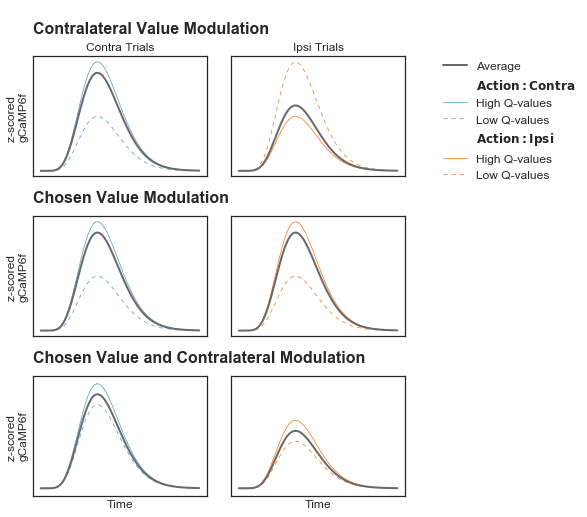

In [139]:
print('version 1 with legend outside')

figure = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(6, 3, height_ratios = [0.3, 1,0.1, 1, 0.1, 1], width_ratios = [1, 1, 0.05])

############################ LEGEND AND OTHER AESTHETICS PARAMS ############################
lax = plt.subplot(gs[1,2]) # MUST be 1,2... some hacky issue. 

l1, = lax.plot([], [], linewidth = LW_AVG, color = 'dimgrey', label = 'Average')

l2 = lax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = lax.plot([], color = c_col, label = 'High Q-values', lw = LW)
l4, = lax.plot([], color = c_col,label = 'Low Q-values', lw = LW, dashes=(5, 5))

l5 = lax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = lax.plot([], [], label = 'Low Q-values ', color  = i_col, lw = LW, dashes=(5, 5))
l7, = lax.plot([], [], linewidth = LW, label = 'High Q-values', color = i_col)

plt.legend()
lgd = plt.legend(handles = [l1, l2, l3, l4, l5, l7, l6], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., fontsize = sz)

clear_figure(lax)


TITLE_FONT_SZ = 16
sz = 12 

############################ CONTRALATERAL VALUE MODULATION ############################

ax = plt.subplot(gs[0, :])
clear_figure(ax)
ax.text(0, 0.25, 'Contralateral Value Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[1, 0])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_title('Contra Trials', size = sz)



ax = plt.subplot(gs[1, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['--', '-'], color = i_col, avg_xy = [x, y * 0.6])
ax.set_title('Ipsi Trials', size = sz)



############################ CHOSEN VALUE MODULATION ############################
ax = plt.subplot(gs[2, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')


ax = plt.subplot(gs[3, 0])

plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)



ax = plt.subplot(gs[3, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = i_col, avg_xy = [x, y * 0.9])


############################ CHOSEN VALUE AND CONTRALATERAL MODULATION ############################
ax = plt.subplot(gs[4, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value and Contralateral Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[5, 0])

plot_schematic(ax, [x, y * 2], [x, y * 1.6], ['-', '--'], color = c_col, avg_xy = [x, y * 1.8])
ax.set_ylim([-0.03, 0.45])

ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_xlabel('Time', size = sz)


ax = plt.subplot(gs[5, 1])
plot_schematic(ax, [x, y * 1.3], [x, y * 0.9], ['-', '--'], color = i_col, avg_xy = [x, y * 1.1])
ax.set_ylim([-0.03, 0.45])
ax.set_xlabel('Time', size = sz)

plt.subplots_adjust(right = 0.75)
plt.savefig('figs/Fig2_theories', dpi=200)

print('Done')


version 2 with legend inside
Done


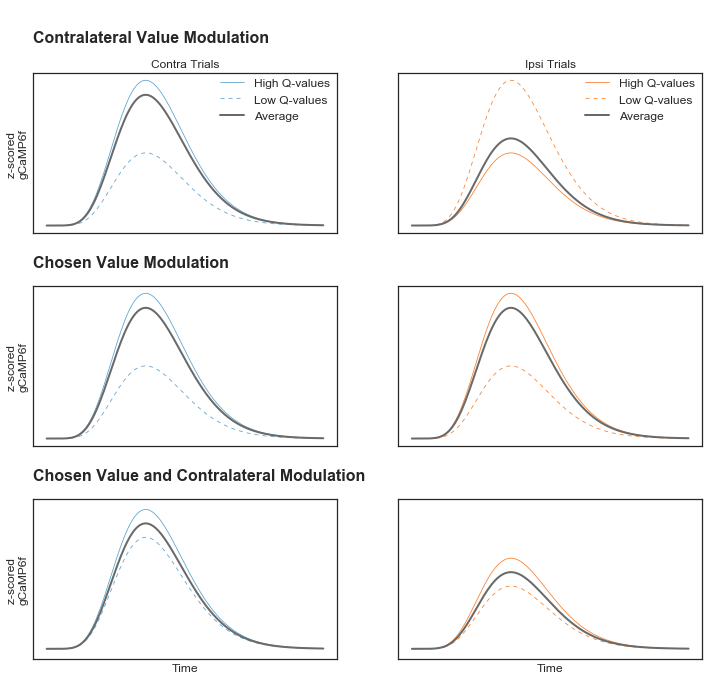

In [140]:
print('version 2 with legend inside')

figure = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(6, 2, height_ratios = [0.3, 1,0.1, 1, 0.1, 1])


TITLE_FONT_SZ = 16
sz = 12 

############################ CONTRALATERAL VALUE MODULATION ############################

ax = plt.subplot(gs[0, :])
clear_figure(ax)
ax.text(0, 0.25, 'Contralateral Value Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[1, 0])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_title('Contra Trials', size = sz)

#>>>>>>>>>>>legend >>>>>>>>>>>

l1, = ax.plot([], [], linewidth = LW_AVG, color = 'dimgrey', label = 'Average')

l2, = ax.plot([], color = c_col, label = 'High Q-values', lw = LW)
l3, = ax.plot([], color = c_col,label = 'Low Q-values', lw = LW, dashes=(5, 5))
lgd = plt.legend(handles = [l2, l3, l1], bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0., fontsize = sz)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ax = plt.subplot(gs[1, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['--', '-'], color = i_col, avg_xy = [x, y * 0.6])
ax.set_title('Ipsi Trials', size = sz)


#>>>>>>>>>>>legend >>>>>>>>>>>

l1, = lax.plot([], [], linewidth = LW_AVG, color = 'dimgrey', label = 'Average')

l2, = lax.plot([], color = i_col, label = 'High Q-values', lw = LW)
l3, = lax.plot([], color = i_col,label = 'Low Q-values', lw = LW, dashes=(5, 5))

lgd = plt.legend(handles = [l2, l3, l1], bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0., fontsize = sz)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


############################ CHOSEN VALUE MODULATION ############################
ax = plt.subplot(gs[2, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')


ax = plt.subplot(gs[3, 0])

plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = c_col, avg_xy = [x, y * 0.9])
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)



ax = plt.subplot(gs[3, 1])
plot_schematic(ax, [x, y], [x, y * 0.5], ['-', '--'], color = i_col, avg_xy = [x, y * 0.9])


############################ CHOSEN VALUE AND CONTRALATERAL MODULATION ############################
ax = plt.subplot(gs[4, :])
clear_figure(ax)
ax.text(0, 0, 'Chosen Value and Contralateral Modulation', size = TITLE_FONT_SZ, weight = 'bold', horizontalalignment = 'left')

ax = plt.subplot(gs[5, 0])

plot_schematic(ax, [x, y * 2], [x, y * 1.6], ['-', '--'], color = c_col, avg_xy = [x, y * 1.8])
ax.set_ylim([-0.03, 0.45])

ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_xlabel('Time', size = sz)


ax = plt.subplot(gs[5, 1])
plot_schematic(ax, [x, y * 1.3], [x, y * 0.9], ['-', '--'], color = i_col, avg_xy = [x, y * 1.1])
ax.set_ylim([-0.03, 0.45])
ax.set_xlabel('Time', size = sz)

plt.savefig('figs/Fig2_v2_theories', dpi=200)

print('Done')

Text(0.5,0,'Time(s)')

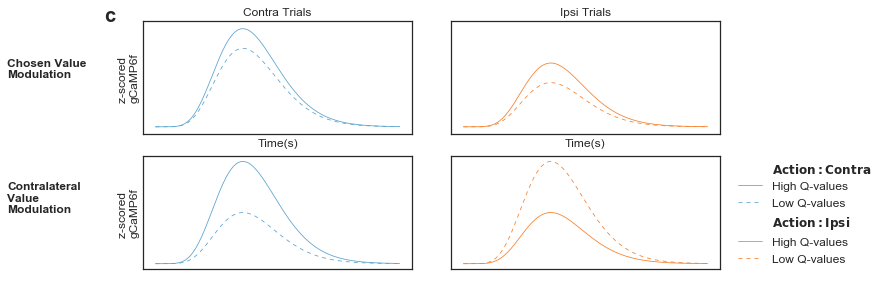

In [16]:

sz = 12
figure = plt.figure(figsize=(12,12))
subfigs = np.array(['a', 'b','c'])
gs = gridspec.GridSpec(5, 3, width_ratios = [0.2, 1, 1])


# THEORY PLOTS 
ax = plt.subplot(gs[3, 0])


ax.text(-0.8, 0.5, 'Contralateral\nValue\nModulation', weight = 'bold', size = sz)
ax.axis('off')

ax = plt.subplot(gs[2, 0])

ax.text(-0.8, 0.5, 'Chosen Value\nModulation', weight = 'bold', size = sz)
ax.axis('off')
ax.annotate(subfigs[2], xy = (1, 1), xytext = (1, 1), fontsize=20,
                    weight='semibold')

# contra theory 
ax = plt.subplot(gs[3, 1])
# ax.plot(x, y * 0.9, linewidth = 2, color = 'dimgrey')

ax.plot(x, y, linewidth = 0.8, color  = c_col)
ax.plot(x, y * 0.5, linewidth = 0.8, linestyle = '--', color  = c_col, dashes=(5, 5))
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)


ax = plt.subplot(gs[3, 2])

# l1, = ax.plot(x, y * 0.6, linewidth = 2, color = 'dimgrey', label = 'Average')

l2 = ax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = ax.plot([], color = c_col, label = 'High Q-values', lw = 0.8)
l4, = ax.plot([], color = c_col, linestyle = '--', label = 'Low Q-values', lw = 0.8, dashes=(5, 5))

l5 = ax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = ax.plot(x, y, linewidth = 0.8, label = 'Low Q-values ', color  = i_col, ls = '--', dashes=(5, 5))
l7, = ax.plot(x, y* 0.5, linewidth = 0.8, label = 'High Q-values', color = i_col)

set_figure(ax)

lgd = plt.legend(handles = [l2, l3, l4, l5, l7, l6], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = sz)
# ax = plt.subplot(gs[0, 2])
ax = plt.subplot(gs[2, 1])
# ax.plot(x, y * 1.8, linewidth = 2, color = 'dimgrey')

ax.plot(x, y * 1.6, linewidth = 0.8, color  = c_col, linestyle = '--', dashes=(5, 5))
ax.plot(x, y * 2, linewidth = 0.8, color  = c_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_title('Contra Trials', size = sz)
ax.set_xlabel('Time(s)', size = sz)

ax = plt.subplot(gs[2, 2])
# ax.plot(x, y * 1.1, linewidth = 2, color = 'dimgrey')

ax.plot(x, y *1.3, linewidth = 0.8, color = i_col)
ax.plot(x, y * 0.9, linewidth = 0.8, color = i_col, linestyle = '--', dashes=(5, 5))
ax.set_ylim([-0.03, 0.45])
set_figure(ax)
ax.set_title('Ipsi Trials', size = sz)


ax.set_xlabel('Time(s)', size = sz)

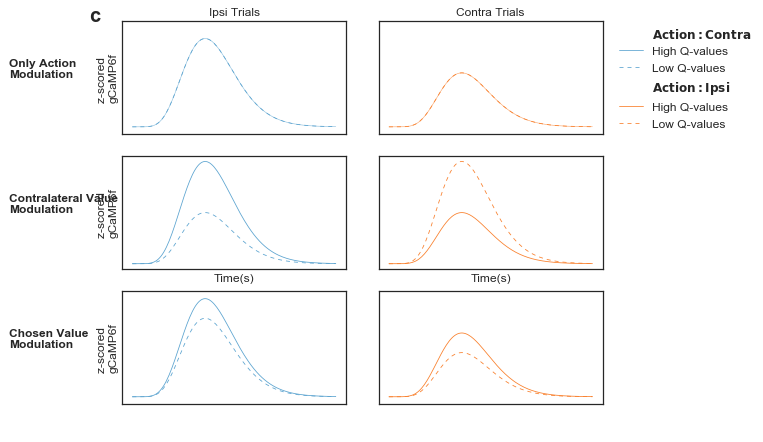

In [25]:
# CONTRA VS IPSI sz = 12
figure = plt.figure(figsize=(10,12))
subfigs = np.array(['a', 'b','c'])
gs = gridspec.GridSpec(5, 3, width_ratios = [0.2, 1, 1])


    

# THEORY PLOTS 
ax = plt.subplot(gs[2, 0])


ax.text(-0.8, 0.5, 'Only Action\nModulation', weight = 'bold', size = sz)
ax.axis('off')
ax.annotate(subfigs[2], xy = (1, 1), xytext = (1, 1), fontsize=20,
                    weight='semibold')

ax = plt.subplot(gs[3, 0])

ax.text(-0.8, 0.5, 'Contralateral Value \nModulation', weight = 'bold', size = sz)
ax.axis('off')

ax = plt.subplot(gs[4, 0])

ax.text(-0.8, 0.5, 'Chosen Value \nModulation', weight = 'bold', size = sz)
ax.axis('off')

############################ ONLY ACTION MODULATION ############################
ax = plt.subplot(gs[2, 1])
# ax.plot(x, y * 0.9, linewidth = 2, color = 'dimgrey')

ax.plot(x, y * 1.8, linewidth = 0.8 - 0.2 , alpha = 0.7, color  = c_col)
ax.plot(x, y * 1.8, linewidth = 0.8, linestyle = '--', color  = c_col, dashes=(5, 5))
ax.set_ylim([-0.03, 0.45])


set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_title('Ipsi Trials', size = sz)


ax = plt.subplot(gs[2, 2])

# l1, = ax.plot(x, y * 0.6, linewidth = 2, color = 'dimgrey', label = 'Average')

l2 = ax.fill_between([], [], [], color = 'w', label=r'$\mathbf{Action:Contra}$')
l3, = ax.plot([], color = c_col, label = 'High Q-values', lw = 0.8)
l4, = ax.plot([], color = c_col, linestyle = '--', label = 'Low Q-values', lw = 0.8, dashes=(5, 5))

l5 = ax.fill_between([], [], [], color = 'w', label = r"$\mathbf{Action:Ipsi}$")
l6, = ax.plot([], linewidth = 0.8, label = 'High Q-values ', color  = i_col)
l7, = ax.plot([], linewidth = 0.8, label = 'Low Q-values', color = i_col, ls = '--', dashes=(5, 5))


ax.plot(x, y * 1.1, linewidth = 0.8, color = i_col, ls = '--', dashes=(5, 5))
ax.plot(x, y* 1.1, linewidth = 0.8 - 0.2 , alpha = 0.7, color  = i_col)
ax.set_ylim([-0.03, 0.45])

set_figure(ax)
ax.set_title('Contra Trials', size = sz)

lgd = plt.legend(handles = [l2, l3, l4, l5, l6, l7], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = sz)
# ax = plt.subplot(gs[0, 2])


############################ ONLY VALUE MODULATION ############################
ax = plt.subplot(gs[3, 1])
# ax.plot(x, y * 1.8, linewidth = 2, color = 'dimgrey')

ax.plot(x, y, linewidth = 0.8, color  = c_col)
ax.plot(x, y * 0.5, linewidth = 0.8, linestyle = '--', color  = c_col, dashes=(5, 5))
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)
ax.set_xlabel('Time(s)', size = sz)

ax = plt.subplot(gs[3, 2])
# ax.plot(x, y * 1.1, linewidth = 2, color = 'dimgrey')

ax.plot(x, y, linewidth = 0.8, label = 'High Q-values', color = i_col, ls = '--', dashes=(5, 5))
ax.plot(x, y * 0.5, linewidth = 0.8, label = 'Low Q-values ', color  = i_col)

set_figure(ax)

ax.set_xlabel('Time(s)', size = sz)


############################ VALUE + ACTION MODULATION ############################
ax = plt.subplot(gs[4, 1])
# ax.plot(x, y * 1.8, linewidth = 2, color = 'dimgrey')

ax.plot(x, y * 1.6, linewidth = 0.8, color  = c_col, linestyle = '--', dashes=(5, 5))
ax.plot(x, y * 2, linewidth = 0.8, color  = c_col)
ax.set_ylim([-0.03, 0.45])
set_figure(ax)
ax.set_ylabel('z-scored \ngCaMP6f', size = sz)

ax = plt.subplot(gs[4, 2])
# ax.plot(x, y * 1.1, linewidth = 2, color = 'dimgrey')

ax.plot(x, y *1.3, linewidth = 0.8, color = i_col)
ax.plot(x, y * 0.9, linewidth = 0.8, linestyle = '--', color = i_col, dashes=(5, 5))
ax.set_ylim([-0.03, 0.45])
set_figure(ax)






# Figure 3


Done


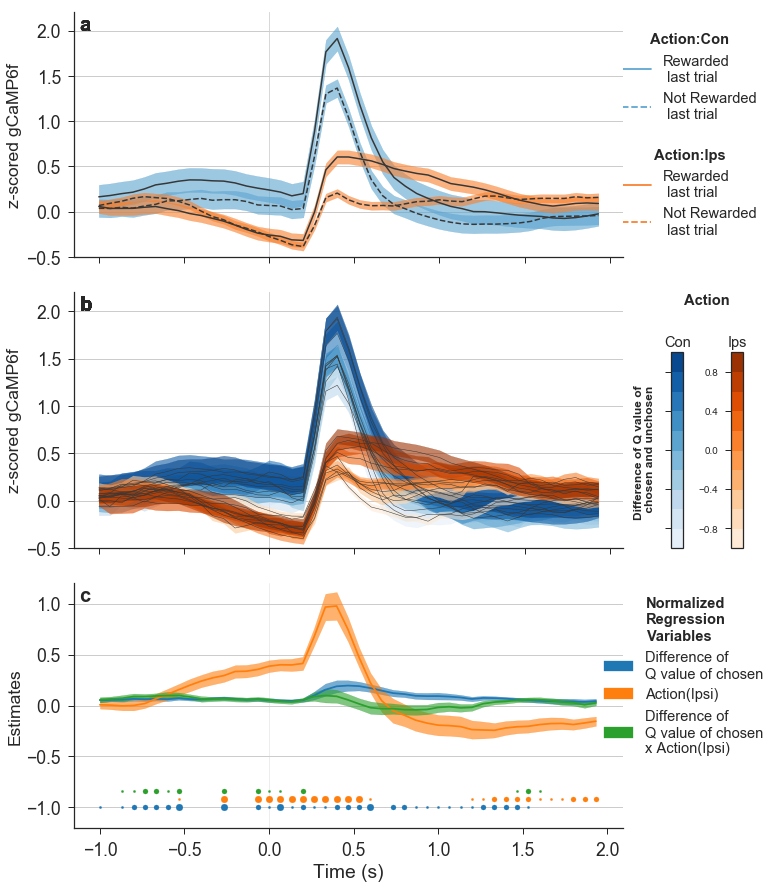

In [156]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q value of \n chosen and unchosen'
ylims = [[-0.5, 2.2], [-0.5, 2.2]]
figure = plt.figure(figsize=(12, 15))
subfigs = np.array(['a', 'b', 'c'])
gs = gridspec.GridSpec(4, 3,
                       width_ratios=[9, 0.2, 0.2], height_ratios = [1, 0.1, 0.8, 1])



gs.update(wspace=0.25)

qlims = np.unique(df_corr_DMS['b' + Q_to_plot].dropna())
line_styles = ['--', '-']


for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):
    

    j = 0
    timelocked = 'g_lp'
    tl_name = 'Lever Presentation' 
    palettes = [ 'Blues', 'Oranges']

        
    if tl_name == 'Reward':
        categories = [1, 0]
        column = 'Reward'
        cat_names = ['CS+', 'CS-']
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
        cat_names = categories
            
                    
    # legend plotting 1. colorbar for the q values 
                
        
    lax2 = plt.subplot(gs[i, -2])

    for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
 
        color_palette = sns.color_palette(palette, len(qlims))

  
        cmap = ListedColormap(color_palette.as_hex())
        bounds = [x.left for x in qlims] + [qlims[-1].right]
        norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
        if i == 1:

            lax = plt.subplot(gs[i + 1, j + 1 + p_i])
            dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
            lax.cla()
            cbar = plt.colorbar(dummy_plot, cax = lax)

                
            cbar.ax.set_title(subcat, size = 'x-small')


            if p_i == 0:
                cbar.ax.set_yticklabels([])
                cbar.set_label(Q_to_plot_name, size =  12, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
            if p_i == 1:
                cbar.ax.tick_params(labelsize = 10)
#                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
        if i == 0:
                
            ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
            ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                
            lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
                                 fontsize = 'x-small', loc= (p_i + 8), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
            plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')

            if p_i == 0:
                lax2.add_artist(lgd)

            lax2.axis('off')

    if i == 1:
        with sns.axes_style("white"):
            lax_title = plt.subplot(gs[1, 1:])
            lax_title.text(0.5, 0.5, column, size = 'x-small', weight = 'bold', ha = 'center')

            lax_title.axis('off')
            
    
    ax = plt.subplot(gs[i: (i * 2 + 1 ), j*3])



    for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
        df_src = df_corr_DMS[df_corr_DMS[column] == subcat]

        color_palette = sns.color_palette(palette, len(qlims))



        for l_i, col in zip(lines, color_palette):

            # plot gcamps
            if src == 'qval':
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                ls_i = '-'
                lw = 0.5
            elif src == 'gcamp':
                gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(gcamp, axis = 0)
                col = color_palette[5]
                lw = 1.5
                ls_i = line_styles[l_i]

            error = np.std(y, axis = 0) / np.sqrt(NS)
            ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
            ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
            ax.annotate(subfigs[i], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
#                 # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
            plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
            if j == 0:
                plt.ylabel('z-scored gCaMP6f', size = 'small')

                # x axis 

            plt.xlabel('')
            ax.xaxis.set_ticklabels([])
                
                # grid lines
            ax.yaxis.grid(True)
            ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

i = 2
ax = plt.subplot(gs[-1, 0])
lax = plt.subplot(gs[-1, 1:])
Q_vals = 'Q_ch_diff'

ylim = [-1.2, 1.2]
sig = [0.05, 0.01, 0.001]
pval_gap = 0.08 

df_src = pd.read_csv('data/DMS/_lever_m.csv')
df_src = df_src[df_src['names']!= '(Intercept)']
df_src.loc[df_src['names'] == Q_vals + ':ActionIps', 'Estimate'] = -df_src[df_src['names'] == Q_vals + ':ActionIps'].Estimate
df_src.loc[df_src['names'] == 'ActionIps', 'Estimate'] = -df_src[df_src['names'] == 'ActionIps'].Estimate
        
        
num_var = len(np.unique(df_src['names']))
sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', 
             ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], 
                                    sns.color_palette('tab10', num_var ))):
    df_i = df_src[df_src['names'] == n]
    ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
    if ((i == 3) and (j == 1)):
        pval_gap = 0.12
    for s_i, s in enumerate(sig):
        x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
        y = np.ones(len(x)) * -1 + ln_i * pval_gap

        ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
        if n == 'Q_ch_diff:ActionIps':
            n = 'Difference of \nQ value of chosen \nx Action(Ipsi)'
        if n == 'Q_ch_diff':
            n = 'Difference of \nQ value of chosen'
        if n == 'ActionIps':
            n = 'Action(Ipsi)'
    lax.fill_between([], [], [], color = col, label = n)



l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                             fontsize = 'x-small', loc = l, bbox_to_anchor=(0.2, 1.0))
            
            

plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
lax.axis('off')



# add subfig label
ax.annotate(subfigs[i], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                

        
ax.set_ylim(ylim)

ax.set_ylabel('Estimates', size = 'small')
ax.set_xlabel('Time (s)')

                
ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

plt.savefig('figs/Fig3', dpi=200)
print('Done')


# Figure 4


Done


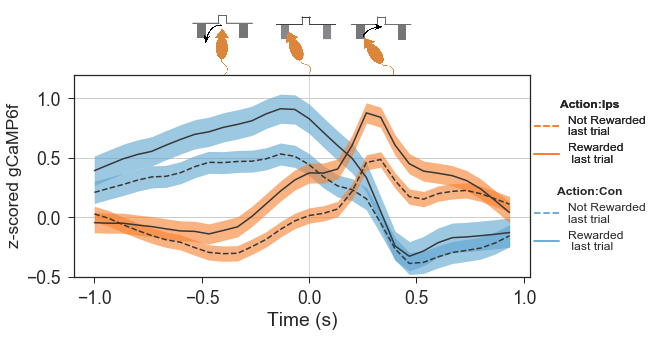

In [142]:


figure = plt.figure(figsize=(10, 5))
# subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[9, 1], height_ratios = [0.3, 1], hspace=0)
line_styles = ['--', '-']

#schematic
ax = plt.subplot(gs[0,0])
im = plt.imread('figs/schematics/schematic2.jpg')
ax.imshow(im)
ax.axis('off')
# ax.set_title('Timelocked at ' + tl_name)


# ax.annotate('a', (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
#                     weight='semibold', va='top', ha='left')
                

# legends

palettes =  ['Blues', 'Oranges']

categories = ['Con', 'Ips']
column = 'Action'
cat_names = categories

timelocked = 'g_choice'
tl_name = 'Lever Press (Choice)'
lines = np.arange(2)

lax2 = plt.subplot(gs[1, 1])
for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
    color_palette = sns.color_palette(palette, 10)
    ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\nlast trial')
    ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')

    lgd = plt.legend(bbox_to_anchor = (1.5,0.5), handles = [ln1, ln2], 
                     fontsize = 'xx-small', loc= (p_i * 3 + 1), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
    plt.setp(lgd.get_title(),fontsize='xx-small', weight = 'bold')

    lax2.add_artist(lgd)
    lax2.axis('off')


ax = plt.subplot(gs[1,0])

        

for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
    df_src = df_corr_DMS[df_corr_DMS[column] == subcat]
    color_palette = sns.color_palette(sns.color_palette(palette, 10))


    for l_i, col in zip(lines, color_palette):


        gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
        x = np.arange(-LEN_BEFORE/15, LEN_BEFORE/ 15, 1/15)
        y = np.mean(gcamp, axis = 0)[:30]
        col = color_palette[5]
        lw = 1.5
        ls_i = line_styles[l_i]

        error = np.std(y, axis = 0) / np.sqrt(NS)
        ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                

        
        plt.ylim(-0.5, 1.2)

        
        plt.ylabel('z-scored gCaMP6f', size = 'small')

        plt.xlabel('Time (s)')

        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

plt.subplots_adjust(bottom = 0.15)
plt.savefig('figs/Fig4', dpi=200)
print('Done')

